## Before Tensorflow: How to build a neural network using just the basics in Python

A network is a series of connections between nodes where each node is connected by a well-defined path. This system of nodes and connections are together referred to as a graph. A common analogy is that of a family: a family constitutes different individuals (nodes) who are linked by relationships (connections). The links that connect different nodes to each other in a network are referred to as edges. Similarly, each state is a node and the transformation of a node is defined by the edges.  

In neural networks, nodes are where the computations are performed and edges are the paths along which the operations flow from one node to the next. In this illustration, we define different aspects of a very simple neural network and build a graphical operation. If the graph is very large (a deep or complex neural network) the operations can be performed in parallel on different CPUs (i.e. a computing cluster) as long as the edge connections (mathematical flows between nodes) are preserved. 

A neural network typically consists of operations, variables, and constants.  
Building a network comprises the following the steps:

1> define the variables you expect to have in your graph 

2> define the operations you intend to perform

3> define and build class functions (and methods)

4> define and build your activation function(s)

5> define your ("empty") placeholder functions for computing output of the graph

6> define the order of your operations (we'll use a standard numpy library for this)

7> define and build Session() class and functions

8> initialize the variables, global functions and the session for the graph

9> perform test operations

This may look to be cumbersome, and epecially so if you're trying to build a sophisticated neural network! It would involve days of painful effort in reiteration, validation and debugging if we are building a DNN, but that is not the case here. Trying this out will help us appreciate how much _effort we can save_ using tensorflow (or Theano, PyTorch etc). 

#Let's start by defining the different operations, variables and placeholder functions (the coding style used here is OOP).

The operation class defined here is a node in the network. This super-class will be inherited by other classes that perform specific operations on defined variables. For the purpose of this illustration, we will use just 2 variables: x and y. You can also think of x and y and features, "feat1 = x" and "feat2 = y".

In [1]:
class Operation():
    
    def __init__(self, input_nodes = []):
        self.input_nodes = input_nodes #list of input nodes
        self.output_nodes = [] 
                
        for node in input_nodes:
            node.output_nodes.append(self)
                
        _default_graph.operations.append(self)
  
    def compute(self):
         #does not have a computational operation in the network at this point, 
            #but is placeholder function that will be overwritten by a specific operation that inherits from this class
                #observe that the 'compute' function is defined across classes that inherit from this 
        pass

#### Create an addition class

In [2]:
class add(Operation):
    
    def __init__(self, x, y):
         
        super().__init__([x, y])

    def compute(self, x_var, y_var):
         
        self.inputs = [x_var, y_var]
        return x_var + y_var

#### Create a multiplier class

In [3]:
class multiply(Operation):
     
    def __init__(self, x, y):
        
        super().__init__([x, y])
    
    def compute(self, x_var, y_var):
         
        self.inputs = [x_var, y_var]
        return x_var * y_var

#### Create a matrix multiplier class

In [4]:
class matmul(Operation):
     
    def __init__(self, a, b):
        
        super().__init__([a, b])
    
    def compute(self, a_mat, b_mat):
         
        self.inputs = [a_mat, b_mat]
        return a_mat.dot(b_mat)

In [5]:
#Placeholders

class Placeholder():
    
    #A placeholder is an "empty" node that needs to be provided a value for computing the output
        #this does not have values in the beginning but the values are fed-in as the graph computes previous nodes
        
    def __init__(self):
        
        self.output_nodes = []
        
        _default_graph.placeholders.append(self) #we are appending this placeholder to our default graph as node

In [7]:
#Creating variables class 

class Variable():
    
    def __init__(self, initial_value = None):
        
        self.value = initial_value
        self.output_nodes = []
                 
        _default_graph.variables.append(self) #we are appending this placeholder to our default graph as node

In [8]:
class Graph():
    #let's create the graph that links our operations, placeholders and variables
    
    def __init__(self):
        
        self.operations = []
        self.placeholders = []
        self.variables = []
        
    def set_as_default(self):
        
            #let's define this to be the global _default_graph object which can be accessed by other functions
        
        global _default_graph  
        _default_graph = self

### A Basic Graph Test

In [9]:
g = Graph()

In [10]:
g.set_as_default()

In [11]:
A = Variable(12)  #arbitrarily chosen variable

In [12]:
b = Variable(3)   #arbitrarily chosen variable

In [13]:
x = Placeholder()    #no need to provide since it doesn't expect it as an input

In [14]:
y = multiply(A,x)      

In [15]:
z = add(y,b)        #observe that we run it we don't get it any outputs for y and z! why not?

The reason we don't get any output for add and multiply functions is because we haven't executed the graph yet. For this we need to create the session class which will execute the graph in full 

In [16]:
#Session

In [17]:
import numpy as np

In [19]:
def traverse_postorder(operation):
        
        #this function is to ensure that the graph operations are executed in the right order
        
    nodes_postorder = []   #it's a placeholder list which will be used in the session graph
                            #the placeholder node will have different values depending on whether the node being computed 
                                #is an input node or output node or a Placeholder node (defined above)
    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)

    recurse(operation)
    return nodes_postorder

#for more background information on this refer: 
#https://www.tutorialspoint.com/python/python_tree_traversal_algorithms.htm
#http://interactivepython.org/runestone/static/pythonds/Trees/TreeTraversals.html

In [21]:
class Session:
    
    def run(self, operation, feed_dict = {}):
        """ 
          operation: The operation to compute
          feed_dict: a dictionary mapping placeholders to input values (from the data)  
        """
        
        # Puts nodes in correct order
        nodes_postorder = traverse_postorder(operation)
        
        for node in nodes_postorder:

            if type(node) == Placeholder:
                
                node.output = feed_dict[node]       #the node output will be keyed with that node using feed_dict
                
            elif type(node) == Variable:
                
                node.output = node.value            #the node output will be the value provided in the variable
                
                    #if the node is neither a variable nor a placeholder, then we have an operation node
                
            else: # Operation
                
                node.inputs = [input_node.output for input_node in node.input_nodes] 
                                                #ensuring the input nodes are in order before computing 

                node.output = node.compute(*node.inputs) 
                                                    #the node output will be the compute operation performed on the inputs
                
            # Convert lists to numpy arrays
            if type(node.output) == list:
                node.output = np.array(node.output)
        
        # Return the requested node value
        return operation.output

In [22]:
sess = Session()

In [23]:
result = sess.run(operation=z,feed_dict={x:10})

In [25]:
result    # we should get (12 * 10) + 3 = 123

123

Phew! Our session class works

In [26]:
#Let's run another test for matrix multiplication

In [27]:
g = Graph()

g.set_as_default()

A = Variable([[10,20],[30,40]])
b = Variable([1,1])

x = Placeholder()

y = matmul(A,x)

z = add(y,b)

In [28]:
sess = Session()

In [29]:
result = sess.run(operation=z, feed_dict={x:10})

In [30]:
result

array([[101, 201],
       [301, 401]])

#### Activation function
The activation function determines whether a neuron in a neural network should be activated or not. They are an integral feature of most neural networks, and along with weights and bias, determine the efficacy of the network. 

</n>

<center> y = Activation( &Sigma; (weight * input) + bias) </center>

There are a number of activation functions which vary in computational intensity. Some of the more commonly used functions are 'tanh', 'sigmoid' and 'ReLU'.

For a visual tour of various activation function, refer https://dashee87.github.io/data%20science/deep%20learning/visualising-activation-functions-in-neural-networks/

For a brief background information on this, refer: https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/

In [114]:
#Let's create and visualize a few activation functions

In [115]:
#For tanh activation function

def tanh(z):
    return (2/(1+np.exp(-2*z)))-1

In [116]:
sample_z = np.linspace(-10,10,100)

In [117]:
sample_a = tanh(sample_z)

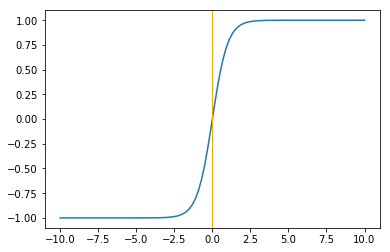

In [118]:
plt.plot(sample_z, sample_a)
plt.axvline(x=0, linewidth=1, color='orange')

In [106]:
#For sigmoid activation function

import matplotlib.pyplot as plt
%matplotlib inline

In [111]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [112]:
sample_a = sigmoid(sample_z)

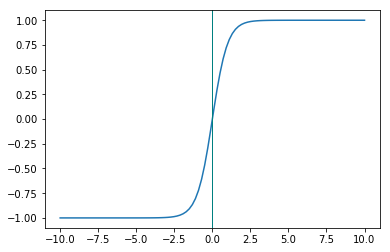

In [169]:
plt.plot(sample_z, sample_a)
plt.axvline(x=0, linewidth=1, color='teal')

In [69]:
#For ReLU activation function

In [70]:
sample_p = np.linspace(-10,10,100)
sample_q = []

In [71]:
for i in range(0,100):
    if sample_p[i] <= 0:
        sample_q.append(0)
    else:
        sample_q.append(sample_p[i])

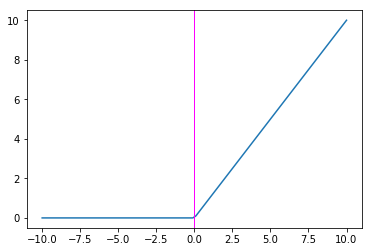

In [105]:
plt.plot(sample_p, sample_q)
plt.axvline(x=0, linewidth=1, color='magenta')

For use in this illustration, let's use the sigmoid operator for our basic network

In [121]:
#Creating the sigmoid operator

In [122]:
class Sigmoid(Operation):
    def __init__(self, z):
        
        super().__init__([z])
    
    def compute(self, z_val):
        return 1/(1+np.exp(-z_val))

#### Let's try out a simple classfication problem

Let's create a simple dataset for classification. We'll use scikit's very useful built-in function and create two datapoint clusters based on two features, x and y. After that we'll plot the datapoints and colour them differently. 

In [123]:
from sklearn.datasets import make_blobs

In [124]:
data = make_blobs(n_samples = 50,n_features=2,centers=2,random_state=25)

In [125]:
features= data[0]
labels = data[1]

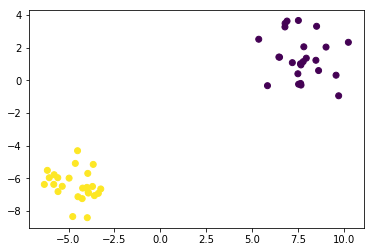

In [126]:
features = data[0]
plt.scatter(features[:,0],features[:,1], c=labels)

In [142]:
#We can see that two datasets have been created and nicely separated into two classes 

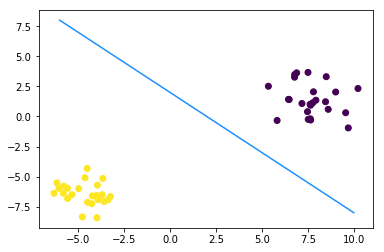

In [155]:
# Let's draw a line that separates the classes
x = np.linspace(-6,10,10)
y = -x+2
plt.scatter(features[:,0],features[:,1],c=labels)
plt.plot(x,y, color='dodgerblue')

Let's understand and describe the data a little bit. We see that the data is grouped into two classes, and lie on the two sides. 
Class 1 on the right (violet) lies more toward the top right quadrant of the box, in other words it lies higher on the x and y axes. We can group the classes in x and y terms.

Class 1 (colored violet) can be marked by x (feat1) > 0 and y (feat2) > -2.5 

Class 2 (colored yellow) can be marked by x (feat1) < 0 and y (feat2) < -2.5 

Let's describe the above mathematically.

The generic equation is
<center> y = mx + c </center>

In this case 
<center> y = -x + 2 , where m = -1</center> 

Let's select two random datapoints from the two classes and check if the graph performs as intended. 

From Class 1: let's select point p1 with coordinates 8,2 (x1,y1) 

From Class 2: let's select point p2 with coordinates -5,-6 (x2,y2) 

weights, w will be initialized as [1,1]

#### Expected output:

If the point belongs to class 1 the final output will approximate to ~1.0

If the point belongs to class 2 the final output will approximate to ~0.0

In [129]:
#defining the perceptron
np.array([1, 1]).dot(np.array([[8],[2]]))

array([10])

In [167]:
np.array([1,1]).dot(np.array([[-5],[-6]]))

array([-11])

Let's understand how the classification works, if:

a) if the output 

In [156]:
#Using an example session graph

In [157]:
g = Graph()

In [158]:
g.set_as_default()

In [159]:
x = Placeholder()

In [160]:
w = Variable([1,1])

In [161]:
b = Variable(0)

In [162]:
z = add(matmul(w,x),b)

In [163]:
a = Sigmoid(z)

In [164]:
sess = Session()

In [165]:
sess.run(operation=a,feed_dict={x:[8,2]})

0.99995460213129761

In [166]:
sess.run(operation=a,feed_dict={x:[-5,-6]})

1.6701421848095181e-05

The above matches the expected output! Looks like our graph network is working as expected.